In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple
import pickle
import time
from torch.utils.data import ConcatDataset, Dataset, Subset
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('D:/downloads/btp/outputforpaper/FashionMnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('D:/downloads/btp/outputforpaper/FashionMnist', train=False, download=True, transform=transforms.ToTensor())

In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 25
rounds = 50
batch_size = 32
in_group_rounds=5
epochs_per_client =5
learning_rate = 2e-2
num_malicious_clients=5

In [4]:
total_train_size, total_test_size

(60000, 10000)

In [5]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()


def average_models(new_model, next, scale):
    if new_model == None:
        new_model = next
        for key in new_model:
            new_model[key] = new_model[key] * scale
    else:
        for key in new_model:
            new_model[key] = new_model[key] + (next[key] * scale)
    return new_model

In [6]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [7]:
def partition_data_label_quantity(
    num_clients, labels_per_client, train_dataset,total_train_size,seed=42):
    trainset=train_dataset
    prng = np.random.default_rng(seed)

    targets = trainset.targets
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    num_classes = len(set(targets))
    times = [0 for _ in range(num_classes)]
    contains = []

    for i in range(num_clients):
        current = [i % num_classes]
        times[i % num_classes] += 1
        j = 1
        while j < labels_per_client:
            index = prng.choice(num_classes, 1)[0]
            if index not in current:
                current.append(index)
                times[index] += 1
                j += 1
        contains.append(current)
    idx_clients: List[List] = [[] for _ in range(num_clients)]
    for i in range(num_classes):
        idx_k = np.where(targets == i)[0]
        prng.shuffle(idx_k)
        idx_k_split = np.array_split(idx_k, times[i])
        ids = 0
        for j in range(num_clients):
            if i in contains[j]:
                idx_clients[j] += idx_k_split[ids].tolist()
                ids += 1
    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]
    return trainsets_per_client

In [8]:
client_datasets = partition_data_label_quantity(num_clients,2,train_dataset,len(train_dataset))

FL

In [9]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()

In [10]:
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [11]:
fl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_fl = []
traffic=[]
weights=[]
load_model=None
total_length_dataset=len(train_dataset)
for i in range(rounds):
    new_model=None
    curr_parameters = global_net.state_dict()
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size()/total_length_dataset
        new_model=average_models(new_model,client_parameters,fraction)
    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
        total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(2*num_clients)
    history_fl.append((train_acc, dev_acc,i))

fl_end_time = time.time()
fl_time = fl_end_time - fl_start_time

After round 1, train_loss = 1.8807, dev_loss = 1.8728, dev_acc = 0.38

After round 2, train_loss = 1.271, dev_loss = 1.2484, dev_acc = 0.7588

After round 3, train_loss = 0.908, dev_loss = 0.8837, dev_acc = 0.7958

After round 4, train_loss = 0.6777, dev_loss = 0.6542, dev_acc = 0.8334

After round 5, train_loss = 0.5243, dev_loss = 0.5028, dev_acc = 0.868

After round 6, train_loss = 0.4552, dev_loss = 0.4363, dev_acc = 0.8774

After round 7, train_loss = 0.3901, dev_loss = 0.3723, dev_acc = 0.8938

After round 8, train_loss = 0.356, dev_loss = 0.3411, dev_acc = 0.8984

After round 9, train_loss = 0.318, dev_loss = 0.3017, dev_acc = 0.9132

After round 10, train_loss = 0.2976, dev_loss = 0.2824, dev_acc = 0.9148

After round 11, train_loss = 0.2708, dev_loss = 0.2572, dev_acc = 0.924

After round 12, train_loss = 0.258, dev_loss = 0.2463, dev_acc = 0.9229

After round 13, train_loss = 0.2364, dev_loss = 0.2248, dev_acc = 0.934

After round 14, train_loss = 0.2261, dev_loss = 0.2157, d

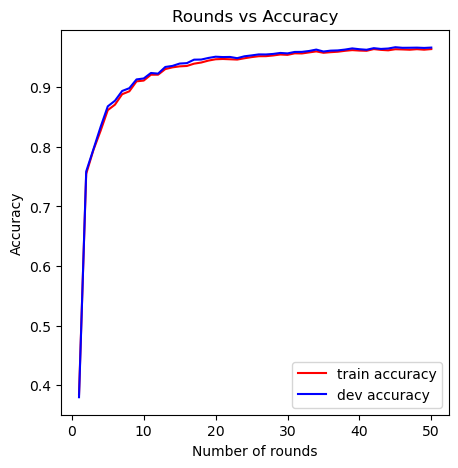

In [12]:
plt.plot([i + 1 for i in range(len(history_fl))], [history_fl[i][0] for i in range(len(history_fl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_fl))], [history_fl[i][1] for i in range(len(history_fl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [13]:
print(max(history_fl))
print(traffic[0])

(0.9640414714813232, 0.9665743708610535, 49)
50


DFL

In [14]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model

In [15]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [16]:
dfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_dfl = []
weights=[]
traffic=[]
load_model=None
total_data_size=len(train_dataset)
for i in range(rounds):
    new_model=None
    for client in clients:
        fraction = client.get_dataset_size()/total_data_size
        if i == 0:
            client_parameters=client.train(curr_parameters)
        else:
            client_parameters = client.train(client.aggregated_parameters())
        for clt in clients:
                clt.recieve_parameters(client.get_client_id(),client_parameters,fraction)
        new_model=average_models(new_model,client_parameters,fraction)
    


    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append((num_clients)*(num_clients-1))
    history_dfl.append((train_acc, dev_acc,i))

dfl_end_time = time.time()
dfl_time  =dfl_end_time - dfl_start_time

After round 1, train_loss = 1.8436, dev_loss = 1.8323, dev_acc = 0.385

After round 2, train_loss = 0.8821, dev_loss = 0.8579, dev_acc = 0.8174

After round 3, train_loss = 0.4648, dev_loss = 0.4454, dev_acc = 0.8651

After round 4, train_loss = 0.3495, dev_loss = 0.3322, dev_acc = 0.9027

After round 5, train_loss = 0.2932, dev_loss = 0.2786, dev_acc = 0.9219

After round 6, train_loss = 0.2547, dev_loss = 0.2402, dev_acc = 0.9345

After round 7, train_loss = 0.2375, dev_loss = 0.2228, dev_acc = 0.9374

After round 8, train_loss = 0.22, dev_loss = 0.2063, dev_acc = 0.9429

After round 9, train_loss = 0.2073, dev_loss = 0.1951, dev_acc = 0.9462

After round 10, train_loss = 0.1947, dev_loss = 0.183, dev_acc = 0.9494

After round 11, train_loss = 0.1892, dev_loss = 0.177, dev_acc = 0.9511

After round 12, train_loss = 0.1784, dev_loss = 0.1669, dev_acc = 0.9544

After round 13, train_loss = 0.1747, dev_loss = 0.1629, dev_acc = 0.9544

After round 14, train_loss = 0.1751, dev_loss = 0.16

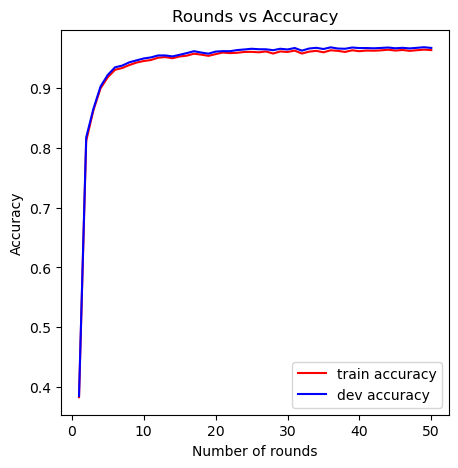

In [17]:
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][0] for i in range(len(history_dfl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][1] for i in range(len(history_dfl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [18]:
print(max(history_dfl))
print(traffic[0])

(0.964152455329895, 0.968156635761261, 48)
600


HDFL

In [19]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 25
rounds = 45
batch_size = 64
in_group_rounds=5
epochs_per_client =5
learning_rate = 2e-2
num_malicious_clients=5

In [20]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
        self.server_id=-1
        self.distance=random.randint(1,100)
        self.client_data_server=[]
    
    def set_server_id(self,client_id):
        self.client_data_server=[]
        self.server_id=client_id
    
    def get_server_id(self):
        return self.server_id
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model
    
    def recieve_data_as_server(self,client_parameter,fraction):
        client_object={"client_parameter":client_parameter,"fraction":fraction}
        self.client_data_server.append(client_object)
    

    def aggregate_parameter_as_server(self):
         local_aggregated_model_as_server=None
         for data in self.client_data_server:
              local_aggregated_model_as_server=average_models(local_aggregated_model_as_server,data["client_parameter"],data["fraction"])
         self.client_data_server.clear()
         return local_aggregated_model_as_server   

In [21]:
def groupDataLength(groups,clients):
    group_dataset_length=[]
    for grp in groups:
        totalcount=0
        for clt in grp:
            totalcount+=clients[clt].get_dataset_size()
        group_dataset_length.append(totalcount)
    return group_dataset_length

In [22]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [25]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
data = []
for client in clients:
    paramerter=client.train(curr_parameters)
    flat_array = np.concatenate([value.cpu().detach().numpy().flatten() for value in paramerter.values()])
    data.append(flat_array)

In [26]:
silhouette_scores = []
range_k=[i for i in range(2,num_clients)]
for k in range_k:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data)
  silhouette_score_val = silhouette_score(data, kmeans.labels_)
  silhouette_scores.append(silhouette_score_val)


best_k_idx = np.argmax(silhouette_scores)
best_k = range_k[best_k_idx]

best_model = KMeans(n_clusters=best_k)
best_model.fit(data)

labels = best_model.labels_
print(labels)
groups=[[] for i in range(0,best_k)]
for i in range(0,num_clients):
    groups[labels[i]].append(i)
print(groups)

# Print the best k value
print("Best k value:", best_k)

[ 5 13 14  1  6 15  2  5  3 11  5  8  7  9 17  3 10  0 12  4 16  8  2  1
  6]
[[17], [3, 23], [6, 22], [8, 15], [19], [0, 7, 10], [4, 24], [12], [11, 21], [13], [16], [9], [18], [1], [2], [5], [20], [14]]
Best k value: 18


In [27]:
print(groups)
group_dataset_length=groupDataLength(groups,clients)

[[17], [3, 23], [6, 22], [8, 15], [19], [0, 7, 10], [4, 24], [12], [11, 21], [13], [16], [9], [18], [1], [2], [5], [20], [14]]


In [28]:
hdfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_hdfl = []
weights=[]
traffic=[]
load_model=None
total_dataset_length=len(train_dataset)
flag=True
for i in range(rounds):
    traffic_single_sum=0
    #chosing the server client with a uniform probability
    server=[]
    for grp in groups:
        traffic_single_sum=traffic_single_sum+len(grp)-1
        server_id=np.random.choice(grp,p=np.ones(len(grp))/len(grp))
        server.append(server_id)
        clients[server_id].set_server_id(server_id)
    #in group mesh decentralized learning
    k=0
    for grp in groups:
        flag=True
        for j in range(in_group_rounds):
            traffic_single_sum=traffic_single_sum+((len(grp)-1)*len(grp))
            for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                if i == 0 and flag :
                    client_parameters=clients[clt].train(curr_parameters)
                elif j == 0:
                    client_parameters=clients[clt].train(load_model)
                else:
                    client_parameters = clients[clt].train(clients[clt].aggregated_parameters())
                for clt_1 in grp:
                        clients[clt_1].recieve_parameters(clt_1,client_parameters,fraction)
            flag=False
        #aggregating on the random choosn server
        for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                t=clients[clt].aggregated_parameters()
                clients[server[k]].recieve_data_as_server(t,fraction)
        k+=1
    #aggregating the parameters
    aggregateds=[]
    for clt in server:
            t=clients[clt].aggregate_parameter_as_server()
            aggregateds.append(t)
    #choosing the server from the amongst server at unifrom probability
    server_id=np.random.choice(server,p=np.ones(len(server))/len(server))
    clients[server_id].set_server_id(server_id)
    traffic_single_sum=traffic_single_sum+len(server)
    #sending the data to the chosen from all the group server
    group_number=0
    for clt in aggregateds:
            fraction=group_dataset_length[group_number]/total_dataset_length
            group_number+=1
            clients[server_id].recieve_data_as_server(clt,fraction)
    #aggregating at the top level server
    traffic_single_sum=traffic_single_sum+num_clients        
    aggregated_parameters_top=clients[server_id].aggregate_parameter_as_server()
    load_model=aggregated_parameters_top.copy()
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(load_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(traffic_single_sum)
    history_hdfl.append((train_acc, dev_acc,i))

hdfl_end_time = time.time()
hdfl_time = hdfl_end_time - hdfl_start_time

After round 1, train_loss = 1.8676, dev_loss = 1.8568, dev_acc = 0.4503

After round 2, train_loss = 1.2592, dev_loss = 1.2408, dev_acc = 0.7361

After round 3, train_loss = 0.826, dev_loss = 0.8075, dev_acc = 0.8234

After round 4, train_loss = 0.5741, dev_loss = 0.5575, dev_acc = 0.8613

After round 5, train_loss = 0.4248, dev_loss = 0.4098, dev_acc = 0.896

After round 6, train_loss = 0.338, dev_loss = 0.3234, dev_acc = 0.9144

After round 7, train_loss = 0.2828, dev_loss = 0.2697, dev_acc = 0.9271

After round 8, train_loss = 0.2447, dev_loss = 0.2325, dev_acc = 0.9364

After round 9, train_loss = 0.2131, dev_loss = 0.2017, dev_acc = 0.9435

After round 10, train_loss = 0.2019, dev_loss = 0.191, dev_acc = 0.9438

After round 11, train_loss = 0.1921, dev_loss = 0.1823, dev_acc = 0.9465

After round 12, train_loss = 0.1903, dev_loss = 0.1832, dev_acc = 0.9434

After round 13, train_loss = 0.1673, dev_loss = 0.1592, dev_acc = 0.9525

After round 14, train_loss = 0.156, dev_loss = 0.14

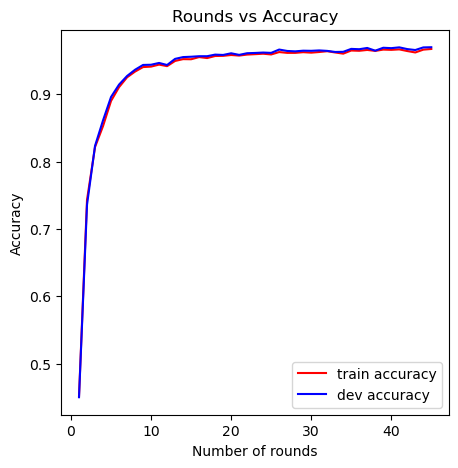

In [29]:
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][0] for i in range(len(history_hdfl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][1] for i in range(len(history_hdfl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [30]:
print(max(history_hdfl))
print(traffic[0])

(0.9672341346740723, 0.9698378443717957, 44)
130


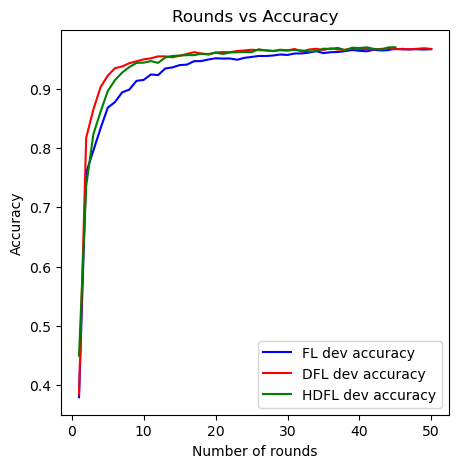

In [31]:
plt.plot([i + 1 for i in range(len(history_fl))], [history_fl[i][1] for i in range(len(history_fl))], color='b', label='FL dev accuracy')
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][1] for i in range(len(history_dfl))], color='r', label='DFL dev accuracy')
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][1] for i in range(len(history_hdfl))], color='g', label='HDFL dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")=
plt.ylabel("Accuracy")
plt.show()

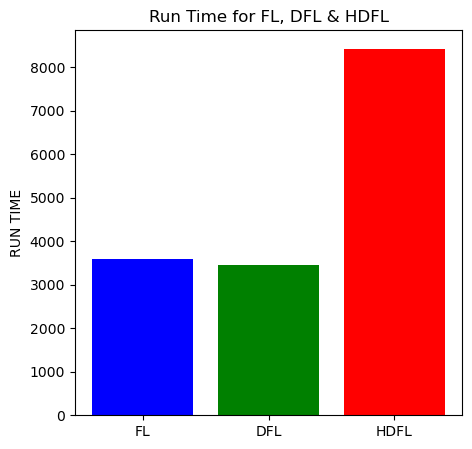

In [32]:
labels = ['FL', 'DFL', 'HDFL']
values = [fl_time, dfl_time, hdfl_time]

# Plot the bar graph
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('')
plt.ylabel('RUN TIME')
plt.title('Run Time for FL, DFL & HDFL')

# Show the plot
plt.show()